# [CDAF] Atividade 2

## Nome e matrícula
Nome: Luís Felipe Ramos Ferreira
Matrícula: 2019022553

## Introdução
Nesta atividade, vamos revisar os conceitos aprendidos em sala de aula sobre estatísticas agregadas. Para esta atividade, usaremos dados do Brasileirão 2022 do FBRef.

## Questão 1
- Baixe o dataset de resultados em https://fbref.com/en/comps/24/2022/schedule/2022-Serie-A-Scores-and-Fixtures
- Crie uma média móvel de 5 jogos, para cada equipe, de cada uma das seguintes estatísticas: xG pró, xG contra, e dif. xG.
- Escolha 4 times para visualizar a série temporal das estatísticas acima. Uma visualização para cada uma das estatísticas, onde a média geral do campeonato é apresentada com uma linha pontilhada em conjunto com a média móvel dos times escolhidos.
- Interprete os resultados. O que isso pode indicar sobre a qualidade ofensiva e defensiva dos times escolhidos?

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import stats
from mplsoccer import PyPizza, FontManager
warnings.filterwarnings('ignore')

In [29]:
df: pd.DataFrame = pd.read_csv("../data/atv02/sportsref.csv")
df.drop(columns=["Day", "Time", "Date", "Attendance", "Venue", "Referee", "Match Report", "Notes"], inplace=True)
df.rename(columns={"xG": "xG_Home", "xG.1": "xG_Away"}, inplace=True)
df["xG_diff"] = df["xG_Home"] - df["xG_Away"]
df

,Wk,Home,xG_Home,Score,xG_Away,Away,xG_diff
0,1,Fluminense,1.6,0–0,0.1,Santos,1.5
1,1,Atl Goianiense,1.4,1–1,1.2,Flamengo,0.2
2,1,Coritiba,1.7,3–0,0.4,Goiás,1.3
3,1,Atlético Mineiro,1.9,2–0,0.6,Internacional,1.3
4,1,Botafogo (RJ),1.5,1–3,2.1,Corinthians,-0.6
...,...,...,...,...,...,...,...
375,38,Bragantino,0.9,0–1,0.6,Fluminense,0.3
376,38,América (MG),2.1,1–1,0.5,Atl Goianiense,1.6
377,38,Goiás,0.2,0–4,1.7,São Paulo,-1.5
378,38,Internacional,1.4,3–0,1.3,Palmeiras,0.1


In [30]:
teams: np.array = df["Home"].unique()
xG_pro_global_moving_average: np.array = np.zeros(38)
xG_against_global_moving_average: np.array = np.zeros(38)
xG_diff_global_moving_average: np.array = np.zeros(38)
window_size: int = 5
for team in teams:
    team_df: pd.DataFrame = df[(df["Home"] == team) | (df["Away"] == team)]
    team_df["xG_pro"] = np.where(team_df["Home"] == team, team_df["xG_Home"], team_df["xG_Away"])
    team_df["xG_against"] = np.where(team_df["Home"] == team, team_df["xG_Away"], team_df["xG_Home"])
    team_df["xG_diff"] = np.where(team_df["Home"] == team, team_df["xG_diff"], -1 * team_df["xG_diff"])

    xG_pro_moving_average: np.array = team_df["xG_pro"].rolling(window=window_size, min_periods=1).mean().to_numpy()
    xG_against_moving_average: np.array = team_df["xG_against"].rolling(window=window_size, min_periods=1).mean().to_numpy()
    xG_diff_moving_average: np.array = team_df["xG_diff"].rolling(window=window_size, min_periods=1).mean().to_numpy()

    """ plt.plot(np.arange(38), xG_pro_moving_average,  marker='o', linewidth=1, markersize=2, label="Pro")
    plt.plot(np.arange(38), xG_against_moving_average, marker='o', linewidth=1, markersize=2, label="Against")
    plt.plot(np.arange(38), xG_diff_moving_average,  marker='o', linewidth=1, markersize=2, label="Difference")
    plt.title(f"{team} moving averages")
    plt.xticks(np.arange(38, step=2))
    plt.xlabel("Week")
    plt.ylabel("xG")
    plt.legend()
    plt.show() """

    xG_pro_global_moving_average += xG_pro_moving_average
    xG_against_global_moving_average = xG_against_moving_average
    xG_diff_global_moving_average += xG_diff_moving_average

xG_pro_global_moving_average /= 20
xG_against_global_moving_average /= 20
xG_diff_global_moving_average /= 20


Para análise, foram escolhidos os clubes que ficaram em 1º, 7º, 13º e 20º colocados no campeonato brasileiro de 2022, uma vez que são clubes espaçados em colocação de forma balanceada, o que irá permitir análises de diferentes casos de performance durante o campeonato. Respectivamente, se tratam dos clubes: Palmeiras, Atlético Mineiro, Goiás e Juventude.

In [31]:
def plot_teams_moving_averages(df: pd.DataFrame, statistic: str, teams: np.array, global_moving_average: np.array, window_size: int) -> None:
    for team in teams:
        team_df: pd.DataFrame = df[(df["Home"] == team) | (df["Away"] == team)]
        team_df["xG_pro"] = np.where(team_df["Home"] == team, team_df["xG_Home"], team_df["xG_Away"])
        team_df["xG_against"] = np.where(team_df["Home"] == team, team_df["xG_Away"], team_df["xG_Home"])
        team_df["xG_diff"] = np.where(team_df["Home"] == team, team_df["xG_diff"], -1 * team_df["xG_diff"])

        xG_pro_moving_average: np.array = team_df[statistic].rolling(window=window_size, min_periods=1).mean().to_numpy()
        plt.plot(np.arange(38), xG_pro_moving_average,  marker='o', linewidth=1, markersize=2, label=team)
        
    plt.plot(np.arange(38), global_moving_average,  linestyle="--", marker='o', linewidth=1, markersize=2, label="Global average")
    plt.title(f"Moving average of {statistic} for {teams}")
    plt.xticks(np.arange(38, step=2))
    plt.xlabel("Week")
    plt.ylabel("xG")
    plt.legend(loc=(0.1, 0.775), fontsize="6.5")
    plt.show()

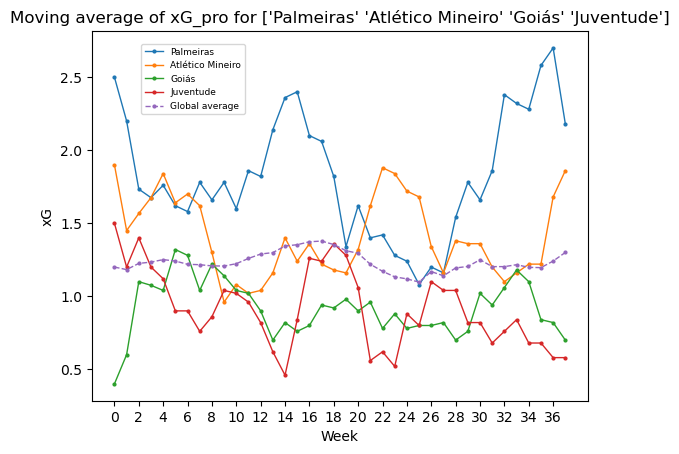

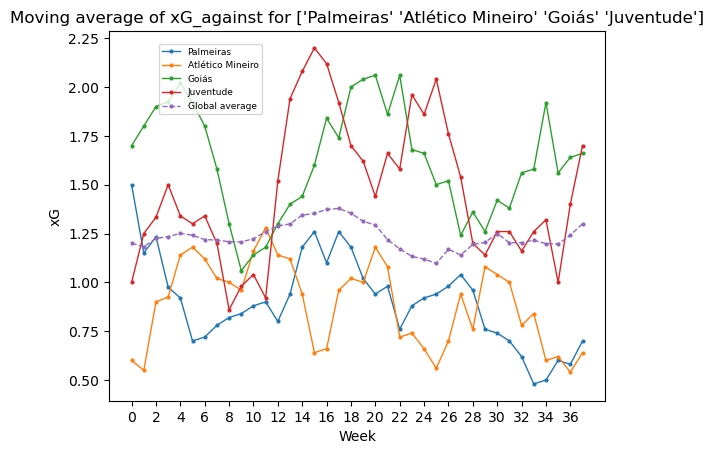

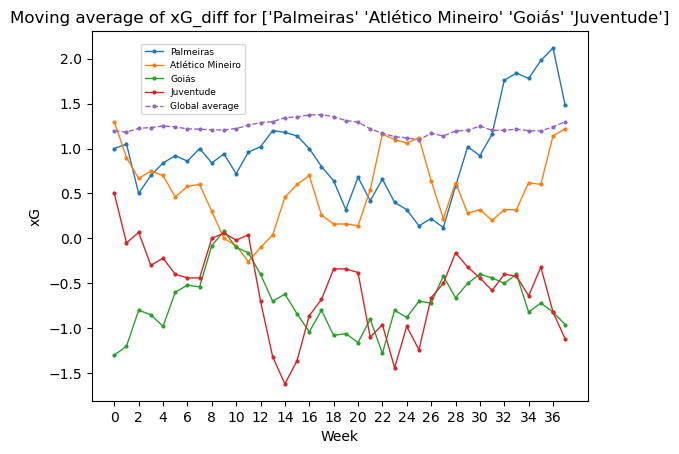

In [32]:
teams: np.array = np.array(["Palmeiras", "Atlético Mineiro", "Goiás", "Juventude"])
statistics: np.array = np.array(["xG_pro", "xG_against", "xG_diff"])
for statistic in statistics:
    plot_teams_moving_averages(df=df, statistic=statistic, teams=teams, global_moving_average=xG_pro_global_moving_average, window_size=window_size)


Em um primeiro momento, é interessante analisar como a média móvel de *xG_pro* e *xG_against* acompanham a posição relativa dos times no campeonato. O Palmeiras, como campeão, está com uma média praticamente sempre "acima" dos outros clubes analisados no quesito gols esperados a favor, enquanto, análogamente, está quase sempre "abaixo" dos outros em relação a gols esperados contra. A mesma situação se repete para o Juventude, último colocado, só que de maneira inversa, conforme podemos esperar. Evidentemente, isso não estabelece uma regra. O Atlético Mineiro, 7º colocado, teve uma média de *xG_against* muito parecida com a do Palmeiras, assim como também teve períodos ao longo do campeonato em que sua média de *xG_pro* foi superior à do campeão.

Em relação ao desempenho dos times, fica claro que aqueles que estão na parte de cima da tabela possuem maior qualidade, tanto ofensivamente quanto defensivamente. Pode-se ver como o Palmeiras e o Atlético Mineiro tem suas séries de médias móveis de *xG_pro* acima da média global e *xG_against* abaixo da média global, de maneira generalizada. O mesmo ocorre de maneira inversa para Goiás e Juventude. Podemos inferir disso então que clubes que ficaram em boas colocações no campeonato possuem proporções de gols feitos esperados acima da média e gols tomados esperados abaixo da média.

O gráfico da média móvel de *xG_diff* nos mostra qye todos os clubes ficaram, praticamente todo o tempo, abaixo do valor médio global, que está em cada período de análise entre 1.0 e 1.5. Disso, podemos ver como o modelo utilizado pode superestimar o número de gols feitos pelo time vencedor de uma partida e subestimar o número de gols feitos pelo time perdedor.

FALAR MAIS AQUI

## Questão 2
- Agora repita a questão 1, plotando as séries temporais dos mesmos times, mas para uma janela móvel de 10 jogos.
- Quais as diferenças entre as séries temporais de 5 e 10 jogos? Em quais situações pode ser vantajoso escolher uma janela à outra?

In [33]:
teams: np.array = df["Home"].unique()
xG_pro_global_moving_average: np.array = np.zeros(38)
xG_against_global_moving_average: np.array = np.zeros(38)
xG_diff_global_moving_average: np.array = np.zeros(38)
window_size: int = 10
for team in teams:
    team_df: pd.DataFrame = df[(df["Home"] == team) | (df["Away"] == team)]
    team_df["xG_pro"] = np.where(team_df["Home"] == team, team_df["xG_Home"], team_df["xG_Away"])
    team_df["xG_against"] = np.where(team_df["Home"] == team, team_df["xG_Away"], team_df["xG_Home"])
    team_df["xG_diff"] = np.where(team_df["Home"] == team, team_df["xG_diff"], -1 * team_df["xG_diff"])

    xG_pro_moving_average: np.array = team_df["xG_pro"].rolling(window=window_size, min_periods=1).mean().to_numpy()
    xG_against_moving_average: np.array = team_df["xG_against"].rolling(window=window_size, min_periods=1).mean().to_numpy()
    xG_diff_moving_average: np.array = team_df["xG_diff"].rolling(window=window_size, min_periods=1).mean().to_numpy()

    """ plt.plot(np.arange(38), xG_pro_moving_average,  marker='o', linewidth=1, markersize=2, label="Pro")
    plt.plot(np.arange(38), xG_against_moving_average, marker='o', linewidth=1, markersize=2, label="Against")
    plt.plot(np.arange(38), xG_diff_moving_average,  marker='o', linewidth=1, markersize=2, label="Difference")
    plt.title(f"{team} moving averages")
    plt.xticks(np.arange(38, step=2))
    plt.xlabel("Week")
    plt.ylabel("xG")
    plt.legend()
    plt.show() """

    xG_pro_global_moving_average += xG_pro_moving_average
    xG_against_global_moving_average = xG_against_moving_average
    xG_diff_global_moving_average += xG_diff_moving_average

xG_pro_global_moving_average /= 20
xG_against_global_moving_average /= 20
xG_diff_global_moving_average /= 20

Os mesmos 4 clubes serão escolhidos, pelo mesmo motivo anterior.

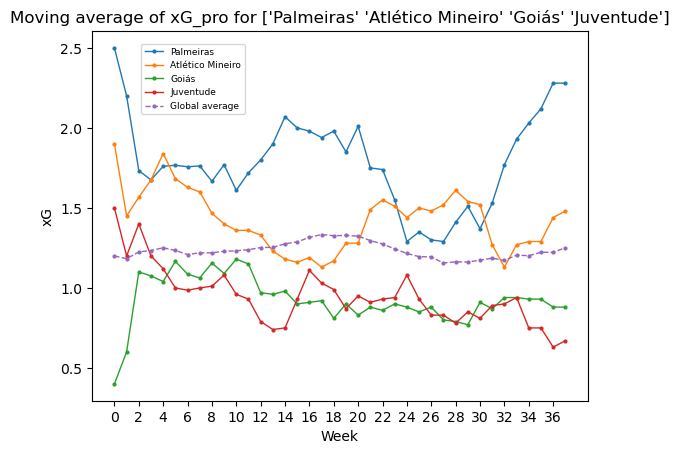

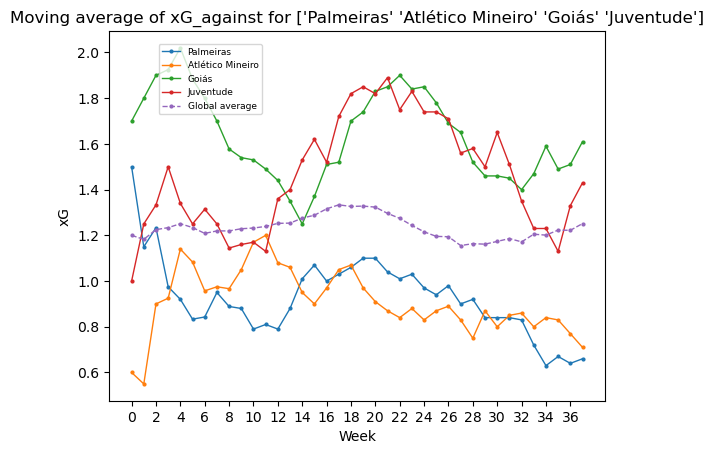

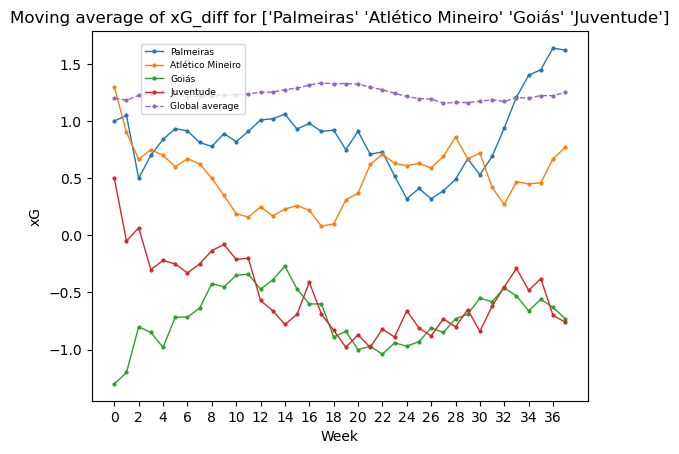

In [34]:
statistics: np.array = np.array(["xG_pro", "xG_against", "xG_diff"])
teams: np.array = np.array(["Palmeiras", "Atlético Mineiro", "Goiás", "Juventude"])
for statistic in statistics:
    plot_teams_moving_averages(df=df, statistic=statistic, teams=teams, global_moving_average=xG_pro_global_moving_average, window_size=window_size)

A janela temporal de 10 jogos traz um grau de informação maior, uma vez que mais jogos são utilizados no cálculo da média representativa de cada período de análise da série temporal gerada.

## Questão 3
- Vá para o link
-- https://fbref.com/en/comps/24/2022/stats/2022-Serie-A-Stats
- Nesta seção de estatísticas, é possível navegar por estatísticas específicas para diferentes aspectos do jogo (finalização, passe, defesa, etc.). Para todos exercícios à partir deste, você terá que selecionar aquelas que julgar mais relevantes para responder as questões.
- Monte um radar plot com 6 atributos relevantes para atacantes e compare 3 jogadores de sua escolha. Justifique a escolha de cada um dos atributos, a escolha da escala dos radares e o tipo de normalização. Interprete os resultados dos radares em termos das qualidades e limitações dos jogadores.
- Ref Soccermatics:
-- https://soccermatics.readthedocs.io/en/lafowards/lesson3/ScoutingPlayers.html
-- https://soccermatics.readthedocs.io/en/lafowards/gallery/lesson3/plot_RadarPlot.html

Os 6 atributos relevantes escolhidos para atacantes e suas justificativas estão descritos a seguir:

- xG (Expected Goals): O principal objetivo do futebol é marcar gols e vencer a partida, e os atacantes são os jogadores cuja função principal é marcar esses gols. A média esperada de gols no campeonato é uma importante métrica para analisarmos quão impactante o atacante será nos campeonatos.

- PrgC (Progressive Carries): Caracterítisca importante para que possamos analisar como os atacantes se comportam na condução de bola, isto é, se possuem foco em apenas recebr a bola e finalizar, ou se possuem foco em conduzila até o gol adversário e auxiliar a equipe an conversão dos gols.

- PrgR (Progressive Passes Received): Pelos mesmos motivos do atributo *PrgC*, poderemos ver como os atacantes analisados se comportam em relação à lances progressivos.

- GlsP90 (Goals Per 90 Minutes): Pelas mesmas justificativas abordadas no tópico da métrica *xG*, poderemos ver quantos gols o atacante de fato fez por partida.

- xGP90 (Expected Goals Per 90 Minutes): Pelas mesmas justificativas abordadas no tópico da métrica *xG*, poderemos ver quantos gols espera-se que o atacante faça por partida.

- npxG (Non Penalty Expected Goals): Com essa métrica atrelada à *xGP90*, poderemos analisar quão dependente de penalisades máximas o jogador é para marcar gols e causar imapcto nas partidas. Isso é importante principalmente considerando o enorme número de memes e piadas na internet direcionados a jogadores que supostamente dependem dos pênaltis para contribuírem para a partida.

Os três jogadores escolhidos serão:

- Pedro (Flamengo)

- Dudu (Palmeiras)

- Hulk (Atlético Mineiro)

Como a temporada analisada é o campeonato brasileiro de 2022, acredito que seja interessante analisar os principais atacantes do país nos últimos anos. São jogadores referências nos clubes que mais se destcaram e venceram títulos desde 2018.

A escala dos radares foi feita com base em percentis calculados a partir dos menores e maiores valores de cada uma das colunas/atributos escolhidos. Dessa forma, poderemos enxergar uma métrica mostrando quão bom o jogador foi na temporada, considerando aquele atributo, numa escala em que 0% seria o pior caso possivel, e 100% seria o melhor caso possível. Para garantir dados limpos e concretos, foram filtrados apenas os atacantes ("FW") com mais de 15 partidas jogadas, com o intuito de evitar o encontro de *outliars* que poderiam gerar confusão.

Um bom exemplo seria o caso do atributo *Expected Goals per 90 minutes*. O jogador Werton do Flamengo possui o valor extremamente alto de 3.1 para esta coluna mas, no entanto, este cálculo se deve ao fato de que ele jogou apenas duas partidas no campeonato. Um número maior de jogos refletiria num valor muito mais realista para o atleta. Por isso, essa filtragem foi realizada. A quantidade de 15 partidas jogadas como média de corte foi escolhida de forma arbitrária, portanto outros valores poderiam gerar resultados melhores para visualizações, embora o número escolhido tenha se mostrado suficiente para as análises.

In [35]:
df: pd.DataFrame = pd.read_csv("../data/atv02/player_standard_stats.csv")
df.drop(columns=["Rk", "Nation", "Age", "Starts", "Born", "Min", "90s", "Matches", "-9999"], inplace=True) # removendo colunas "inúteis"
df.rename(columns={"Gls.1": "GlsP90", "Ast.1": "AstP90", "G+A.1": "G+AP90", "G-PK.1": "G-PKP90", "xG.1": "xGP90", "xAG.1": "xAGP90", "npxG.1": "npxGP90", "npxG+xAG.1": "npxG+xAGP90"}, inplace=True)

hulk_series: pd.Series = df[(df["Player"] == "Hulk") & (df["Squad"] == "Atlético Mineiro")]
pedro_series: pd.Series = df[(df["Player"] == "Pedro") & (df["Squad"] == "Flamengo")]
rony_series: pd.Series = df[(df["Player"] == "Dudu") & (df["Squad"] == "Palmeiras")]

names = ["xG", "npxG", "PrgC", "PrgR", "GlsP90", "xGP90"]
fowards = df[(df["Pos"].str.contains("FW")) & (df["MP"] >= 25)].describe()[names]
max_values: np.array = fowards.loc["max"].to_numpy()
min_values: np.array = fowards.loc["min"].to_numpy()
descriptive_names: np.array = np.array(["Expected Goals", "Non Penalty Expected Goals", "Progressive Carries", "Progressive Passes Received", "Goals Per 90 Minutes", "Expected Goals Per 90 Minutes"])

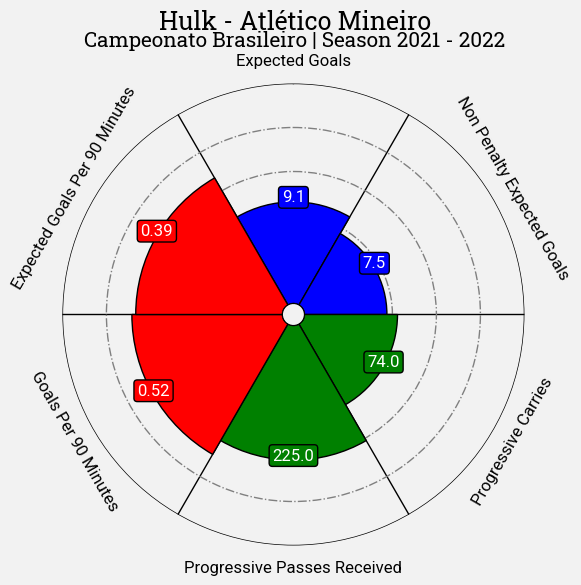

In [36]:
# código copiado do SoccerMatics

values: np.array = hulk_series[names].to_numpy()[0]
values_normalized: np.array = np.round(((values - min_values) / max_values) * 100, 2)
slice_colors = ["blue"] * 2 + ["green"] * 2 + ["red"] * 2
text_colors = ["white"]*6
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    params=descriptive_names,
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    values_normalized,              # list of values
    figsize=(6, 6),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Hulk - Atlético Mineiro", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Campeonato Brasileiro | Season 2021 - 2022",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)
plt.show()

O *Radar Plot* do jogador Hulk mostra o que já se imagina do atleta, isto é, um marcador de gols de altíssima qualidade. Com uma média de 0.52 gols por partida, o jogador marca, aproximadamente, um gol a cada dois jogos. Um detalhe interessante é analisar a diferença entre o *Expected Goals* e o *Non Penalty Expected Goals* do jogador. É comum na internet ver piadas e memes que dizem que o atleta depende de penalidades para marcar e fazer algo nas partidas. O gráfico mostra que há, sim, uma diferença nas duas métricas medidas, ou seja, se desconsiderado a possibilidade de penalidades, ele teria um número de gols marcados menor. No entanto, isso não significa que ele seja dependente deste tipo de lance, ainda mais quando se enxerga que essa diferença é pequena, e sua métrica de *Non Penalty Expected Goals* ainda sim possui um valor considerável.

Em relação a lances progressivos, pode-se inferir que Hulk possui uma maior qualidade em se posicionar e receber passes progressivos do que gerar "arrancadas" e carregar a bola em direção ao gol, embora em diversas situações tenha tido sucesso nesse tipo de jogada. Sua evidente força física provavelmente é um fator que o leva a ser um bom receptor de passes, já que consegue controlar bem a área a sua volta empurrando os adversários e conquistando espaços que outros jogadores poderiam não conseguir.

Em suma, o *Radar Plot* permitiu inferir detalhes importantes sobre o atleta Hulk, que se mostra um artilheiro, que aproveita muito bem suas oportunidades em cobranças de pênaltis e possui uma ótima qualidade no controle de espaço e recebimento de passes.

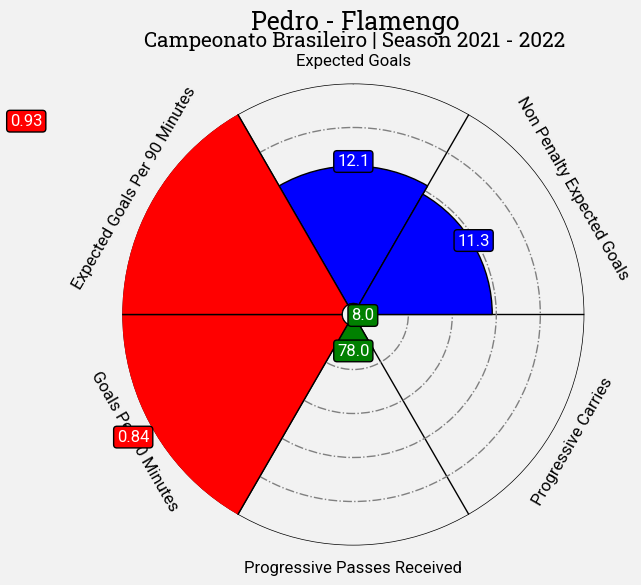

In [37]:
values: np.array = pedro_series[names].to_numpy()[0]
values_normalized: np.array = np.round(((values - min_values) / max_values) * 100, 2)
slice_colors = ["blue"] * 2 + ["green"] * 2 + ["red"] * 2
text_colors = ["white"]*6
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    params=descriptive_names,
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    values_normalized,              # list of values
    figsize=(6, 6),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Pedro - Flamengo", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Campeonato Brasileiro | Season 2021 - 2022",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

plt.show()

O *Radar Plot* do Pedro é notório, já que apresenta um desbalanceamento extremamente grande entre os atributos analisados. Suas médias de *Expected Goals per 90 minutes* e *Goals per 90 minutes* preenchem os percentis porc ompleto, ou seja, dentre todos os atacantes do campeonato, ele é aquele com as melhores métricas nesses atributos. Isso não é nada fora da realidade, já que o jogador é um artilheiro de alto nível, que em 2022 apresentou tão bom desempenho que foi convocado para representar a Seleção Brasileira na Copa do Mundo do Catar. As métricas mostram que espera-se quase 1 gol por jogo para o jogador, o que é extremamente singular.

Em relação às suas métricas de gols esperados, vemos que existe uma leve diferença quando consideramos penalidades máximas, mas anda que prejudique a performance do jogador como um todo. No entanto, as métricas de lances progressivos mostram uma das grandes limitações do jogador. Ele claramente não possui qualidade de carregamento e condução de bola em direção ao gol adversário, tendo como foco total de seus atributos a finalização e a amrcação de gols. Embora possa ser argumentado que o futebol se baseie nisso, o estilo de jogo dos times pode necessitar que os jogadores possuam alguma qualidade nessas métricas de condução e recebimento de passes. 

Em suma, o *Radar Plot* mostrou que o Pedro é um grande goleador. Numericamente falando, o melhor do país no ano de 2022. Sua qualidade de finalização e conversão de chutes em gols é inegável. No entanto, pode-se notar também a limitação absurda que o joagdor tem em condução de bola e recebimento de passes progressivos.

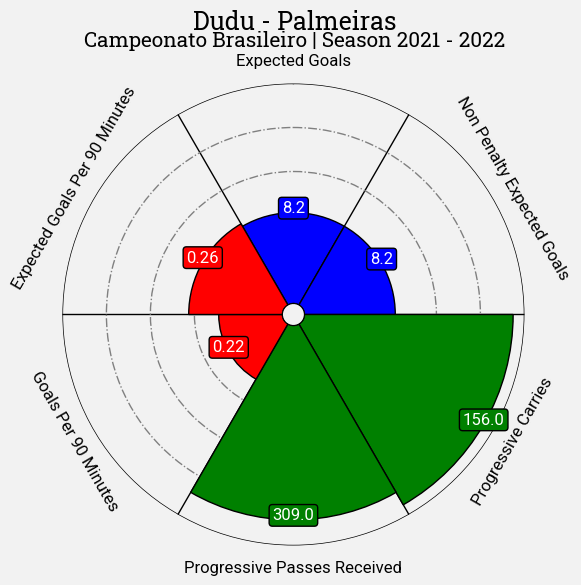

In [38]:
values: np.array = rony_series[names].to_numpy()[0]
values_normalized: np.array = np.round(((values - min_values) / max_values) * 100, 2)
slice_colors = ["blue"] * 2 + ["green"] * 2 + ["red"] * 2
text_colors = ["white"]*6
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    params=descriptive_names,
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    values_normalized,              # list of values
    figsize=(6, 6),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Dudu - Palmeiras", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Campeonato Brasileiro | Season 2021 - 2022",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)
plt.show()

Em contrapartida aos outros atletas analsiados, o *Radar Plot* do Dudu mostrou que ele não possui tanta proeficiência em marcar gols e converter finalizações. Embora possua boas e consideráveis médias de *Expected Goals* e *Non Penalty Expected Goals* (inclusive, podemos notar que elas são iguais, ou seja, o atleta não depende de penalidades para marcar), esse não se mostra como seu principal atributo.

Fica evidente pelo gráfico que o jogador possui um foco muito maior na execução de jogadas progressivas. Suas métricas de *Progressive Carries* e *Progressive Passes Received* são extremamente altas, o que demonstram que o atleta tem alta habilidade na condução de bola e executa/recebe bons passes que resultam em ataques em direção ao gol do adversário.

Em resumo, o *Radar Plot* evidencia as limitações que o jogador Dudu possui na hora de marcar gols, muito provavelmente devido a sua baixa estatura e força física, que limitam sua capacidade no estilo de jogo praticado pelo palmeiras, mas sua qualidade na conversão de lances progressivos é notável.

O *Radar Plot* dos 3 jogadores permitiu identificar diferentes tipos de estilo de jogo para cada um. Hulk aparenta ser um jogador mais completo, com boa capacidade em quase todos os valores analisados. Pedro e Dudu, no entanto, possuem maior qualidade e foco em alguns atributos específicos. Isso de forma alguma significa que um seja necessariamente melhor que o outro. Cada estilog de jogo possui suas vantagens e desvantagens e se encaixam da maneira desejada em cada um de seus clubes.

## Questão 4
- Faça o mesmo que na questão 3, mas para meio campistas.

Os 6 atributos relevantes escolhidos para atacantes e suas justificativas estão descritos a seguir:

- SCA90 (Shot-Creating Actions Per 90 Minutes): A criação de oportunidades de chutes para a equipe é importantíssima para um meio-campista de alto nível.

- GCA90 (Goal-Creating Actions Per 90 Minutes): A criação de oportunidades de gols para a equipe é importantíssima para um meio-campista de alto nível.

- PassLive (Live passes that lead to shots): Muitos meio-campistas possuem como qualidade realizar bons passes com a bola rolando, mostrando versatilidade e visão de jogo.

- PassDead (Dead passes that lead to shots): Muitos meio-campistas possuem como atributo (as vezes até mesmo atributo principal) realizar bons passes com a bola parada, mostrando bom domínio e controle da bola, além de uma qualidade técnica acima da média na cobrança de escanteios, pẽnaltis, faltas, etc.

- TO (Take-ons that lead to shots): Um bom meio-campista muitas vezes contribui com o time ao roubar a bola de adversários e engajar na amrcação bem no meio do campo, gerando boas oportundiades com essa jogada.

- Def (Defensive actions that lead to shots): Um bom meio-campista também, muitas vezes, possui alta qualidade na parte defensiva, criando oportunidades de contra-ataque, por exemplo.

Os três jogadores escolhidos serão:

- Giorgian De Arrascaeta (Flamengo)

- Gustavo Scarpa (Palmeiras)

- Nacho Fernández (Atlético Mineiro)

O argumento para a escolha destes três meio campistas é idêntico ao usado anteriormente. São jogadores fundamentais para seus clubes cujos desempenhos têm estado acima das demais equipes do país nos últimos anos.

In [39]:
df: pd.DataFrame = pd.read_csv("../data/atv02/player_goal_and_shot_creation.csv")
df.drop(columns=["Rk", "Nation", "Age", "Born", "Matches", "-9999"], inplace=True) # removendo colunas "inúteis"

nacho_series: pd.Series = df[(df["Player"] == "Ignacio Fernández") & (df["Squad"] == "Atlético Mineiro")]
arrascaeta_series: pd.Series = df[(df["Player"] == "Giorgian De Arrascaeta") & (df["Squad"] == "Flamengo")]
scarpa_series: pd.Series = df[(df["Player"] == "Gustavo Scarpa") & (df["Squad"] == "Palmeiras")]

names = ["SCA90", "GCA90", "PassLive", "PassDead", "TO", "Def"]
midfielders = df[(df["Pos"].str.contains("MF")) & (df["90s"] >= 15.0)].describe()[names]
max_values: np.array = midfielders.loc["max"].to_numpy()
min_values: np.array = midfielders.loc["min"].to_numpy()
descriptive_names: np.array = np.array(["Shot-Creating Actions Per 90 Minutes", "Goal-Creating Actions Per 90 Minutes", "Live passes that lead to shots", "Dead passes that lead to shots", "Take-ons that lead to shots", "Defensive actions that lead to shots"])

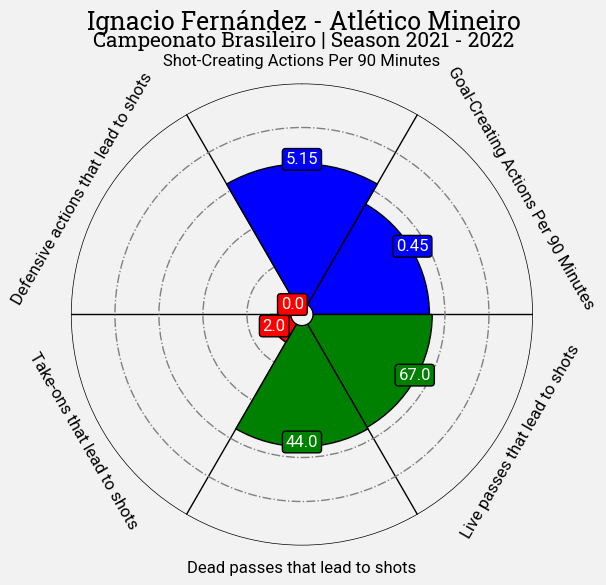

In [40]:
values: np.array = nacho_series[names].to_numpy()[0]
values_normalized: np.array = np.round(((values - min_values) / max_values) * 100, 2)
slice_colors = ["blue"] * 2 + ["green"] * 2 + ["red"] * 2
text_colors = ["white"]*6
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    params=descriptive_names,
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    values_normalized,              # list of values
    figsize=(6, 6),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()

for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Ignacio Fernández - Atlético Mineiro", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Campeonato Brasileiro | Season 2021 - 2022",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)
plt.show()

O *Radar Plot* do atleta Nacho Fernández nos permite enxergar que o atleta possui um estilo de jogo muito mais ofensivo do que defensivo. Ele possui uma média muito alta de *Dead passes that lead to shots* e *Live passes that lead to shots*, oq ue demonstra sua habilidade ímpar de gerar ssistência para sua equipe, seja em bola parada, seja com a bola rolando. Além disso, o atleta possui excelentes números nas métricas relacionadas a criação de chances de chute e gol para seus colegas de equipe.

As métricas de *Takeons* e *defensive actions* mostram que o Nacho Fernández não possui como habilidade principal aprticipar de jogadas defensivas para sua equipe,s endo muito mais crucial na parte ofensiva e gerando boas oportunidades.

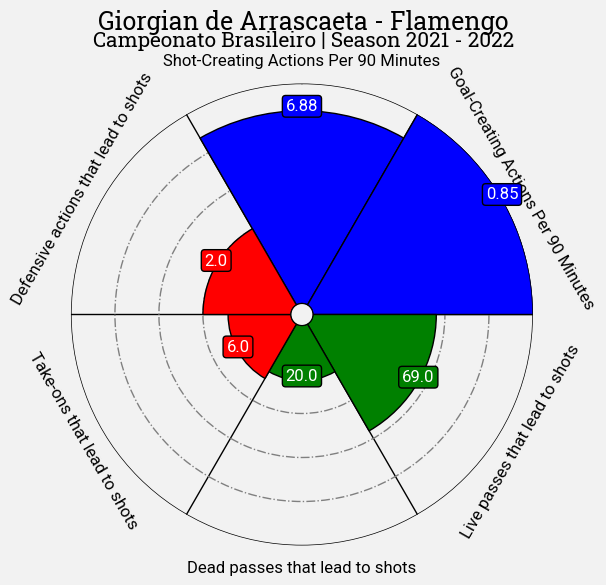

In [41]:
values: np.array = arrascaeta_series[names].to_numpy()[0]
values_normalized: np.array = np.round(((values - min_values) / max_values) * 100, 2)
slice_colors = ["blue"] * 2 + ["green"] * 2 + ["red"] * 2
text_colors = ["white"]*6
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    params=descriptive_names,
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    values_normalized,              # list of values
    figsize=(6, 6),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Giorgian de Arrascaeta - Flamengo", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Campeonato Brasileiro | Season 2021 - 2022",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)
plt.show()

O *Radar Plot* do jogador Arrascaeta mostra o que já se espera dele, um jogador extremamente eficiente no setor ofensivo. Suas métricas de *Shot-Creating Actions* e *Goal-Creating Actions* são extremamente altas. Por partida, ele cria aproximadamente 7 chances de chute e quase 1 chance de gol para sua equipe. Tais números são impressionantes e mostram a grande capacidade e grande importância dele para o Flamengo. 

Suas métricas de valores também são bastante interessantes. O jogador completou por volta de 8 jogadas que serviram de defesa ao seu time  e posteriormente se tornaram oportunidades de chutes ao gol para sua equipe. Além disso, os números do atleta mostram que ele possui uma excelente qualidade em realizar passes "vivos" para seus companheiros de equipe, sendo assim um grande assistente, embora sua qualidade em "passes mortos" não seja tão alta.

Em suma, o *Radar Plot* mostra que Arrascaeta é um jogador completo e extremamente eficiente, que definitivamente é um dos pilares da sua equipe.

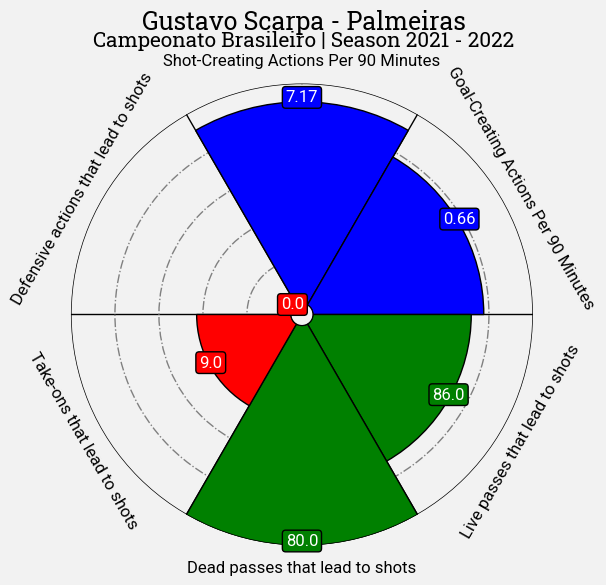

In [42]:
values: np.array = scarpa_series[names].to_numpy()[0]
values_normalized: np.array = np.round(((values - min_values) / max_values) * 100, 2)
slice_colors = ["blue"] * 2 + ["green"] * 2 + ["red"] * 2
text_colors = ["white"]*6
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    params=descriptive_names,
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    values_normalized,              # list of values
    figsize=(6, 6),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Gustavo Scarpa - Palmeiras", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Campeonato Brasileiro | Season 2021 - 2022",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)
plt.show()

O *Radar Plot* do atleta Gustavo Scarpa é impressionante. Seus números calculados sobre *Shots-Creating Actions* e *Goal-Creating Actions* por partida são absurdos. Assim como Arrascaeta, possui uma média de aproximadamente 7 chances de chute e 1 chance de gol criada por partida para sua equipe.

Em relação à passes, ele se demonstra um jogador excpecional para lances em bola parada. São 80 oportunidade de chutes criadas por meio de "passes mortos". Sua qualidade em passes com bola rolando não fica muito atrás. Apesar de não tão impactante comparado aos números gerais do campeonato, Scarpa criou 86 chances de chutes para sua equipe por meio de "passes vivos".

Suas métricas defensivas, no entanto, não são tão interessantes. Isso de forma alguma pode ser visto como um ponto para dizer que ele pe um jogador ruim. Ele possui um foco total no setor ofensivo e teve um sucesso absurdo nessa área. Não atoa o Palmeiras foi campeão do campeonato e ele recebeu diversos prêmios pela sua qualidade.

Os *Radar Plots* dos trẽs jogadores mostrou que eles possuem muito qualidade no setor ofensivo, principalmente na criação de chances para suas equipes. Scarpa e Arrascaeta se mostraram grandes jogadores nesse sentido, e Scarpa principalmente no quesito assistências e passes que geram oportunidades para os times. Nacho Fernández não teve números tão altos quanto os outros dois, embora tenha sido um jogador importantíssimo para o Atlético Mineiro no campeonato.

## Questão 5
- Faça o mesmo que na questão 3, mas para zagueiros.

Os 6 atributos relevantes escolhidos para atacantes e suas justificativas estão descritos a seguir:

- Tkl (Tackles): contestar a posse de bola do adversário, impedindo que ele avance em direção ao seu gol é um atributo fundamental para jogador da parte defensiva.

- TklW (Tackles Won): Com essa métrica, pode-se analisar quão eficiente o zagueiro é na contestação de bolas (como descrito acima). Não

- Tkl% (Percentage of Dribblers Tackled): Muitas das vezes, uma das contestações de bolas que um zagueiro participa é uma tentativa de drible do adversário. Saber se portar/posicionar quando em frente a esse tipo de lance é crucial para o bom desempenho de um zagueiro.

- Sh (Shots Blocked) - Bloquear chutes em direção ao seu gol é fundamental para evitar maiores perigos ao seu time e prevenir que a equipe adversária marque gols.

- Pass (Passes Blocked) - Assim como descito acima para chutes, bloquear passes é fundamental para que um zagueiro tenha um bom desempenho em evitar que a equipe adversária avance em direção ao seu gol.

- Clr (Clearances) - a capacidade do zagueiro em "tirar a bola" em situações de perigo também é uma boa métrica para analisar quão eficiente ele é na parte defensiva.

Os três jogadores escolhidos serão:

- Júnior Alonso (Atlético Mineiro)

- Ayrton Lucas (Flamengo) 

OBS: apesar de não ser um zagueiro propriamente dito, Ayrton Lucas é um atleta que atua na parte defensiva como lateral-esquerdo e, após analisar as tabelas, acreditei que seria interessante utilizar ele nas comparações ao invés de jogador do Flamengo como Rodrigo Caio, David Luiz ou Fabrício Bruno.

- Gustavo Gómez (Palmeiras)

O argumento para a escolha destes três zagueiros é idêntico ao usado anteriormente. São jogadores fundamentais para seus clubes cujos desempenhos têm estado acima das demais equipes do país nos últimos anos.

In [43]:
defensive_stats_df: pd.DataFrame = pd.read_csv("../data/atv02/player_defensive_stats.csv")
defensive_stats_df.drop(columns=["Rk", "Nation", "Age", "Born", "Matches", "-9999"], inplace=True) # removendo colunas "inúteis"
defensive_stats_df.rename(columns={"Tkl.1": "DribblersTkl"})

junior_alonso_series: pd.Series = defensive_stats_df[(defensive_stats_df["Player"] == "Júnior Alonso") & (defensive_stats_df["Squad"] == "Atlético Mineiro")]
ayrton_lucas_series: pd.Series = defensive_stats_df[(defensive_stats_df["Player"] == "Ayrton Lucas") & (defensive_stats_df["Squad"] == "Flamengo")]
gustavo_gomez_series: pd.Series = defensive_stats_df[(defensive_stats_df["Player"] == "Gustavo Gómez") & (defensive_stats_df["Squad"] == "Palmeiras")]

names = ["Tkl", "TklW", "Tkl%", "Sh", "Pass", "Clr"]
defenders = defensive_stats_df[(defensive_stats_df["Pos"].str.contains("DF")) & (defensive_stats_df["90s"] >= 15.0)].describe()[names]
max_values: np.array = defenders.loc["max"].to_numpy()
min_values: np.array = defenders.loc["min"].to_numpy()
descriptive_names: np.array = np.array(["Tackles", "Tackles Won", "Percentage of Dribblers Tackled", "Shots Blocked", "Passes Blocked", "Clearances"])

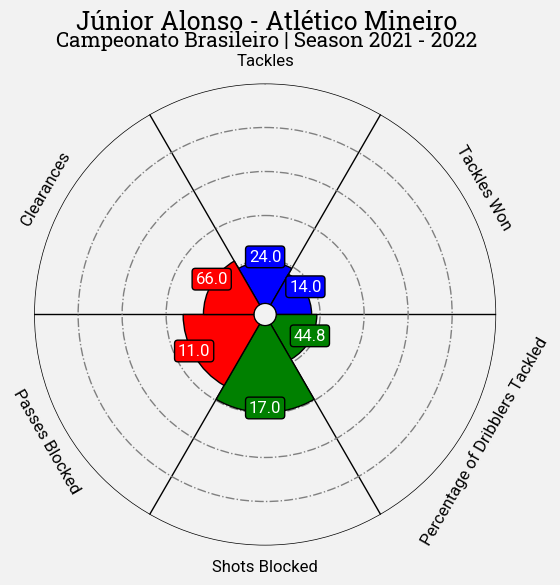

In [44]:
values: np.array = junior_alonso_series[names].to_numpy()[0]
values_normalized: np.array = np.round(((values - min_values) / max_values) * 100, 2)
slice_colors = ["blue"] * 2 + ["green"] * 2 + ["red"] * 2
text_colors = ["white"]*6
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    params=descriptive_names,
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    values_normalized,              # list of values
    figsize=(6, 6),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,´
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Júnior Alonso - Atlético Mineiro", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Campeonato Brasileiro | Season 2021 - 2022",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)
plt.show()

O *Radar Plot* do atleta Júnior Alonso mostrou que se trata de um jogador balanceado, que apresenta bons números em cada uma das métricas analisadas. 

Pode-se ver, no entanto, que os valores calculados não completam áreas tão grandes dos percentis. Nesse sentido, pode-se inferir erroneamente que ele não se enquadra como um dos principais zagueiros do campeonato. Apesar de não ter números absurdos, se mostra um jogador equilibrado e que traz segurança para sua equipe.

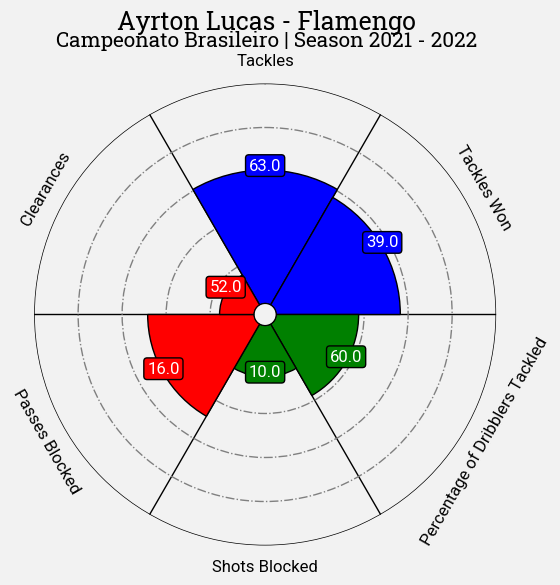

In [45]:
values: np.array = ayrton_lucas_series[names].to_numpy()[0]
values_normalized: np.array = np.round(((values - min_values) / max_values) * 100, 2)
slice_colors = ["blue"] * 2 + ["green"] * 2 + ["red"] * 2
text_colors = ["white"]*6
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    params=descriptive_names,
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    values_normalized,              # list of values
    figsize=(6, 6),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Ayrton Lucas - Flamengo", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Campeonato Brasileiro | Season 2021 - 2022",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)
plt.show()

O *Radar Plot* do jogador Ayrton Lucas, diferente do Júnior Alonso, apresenta valores muito menos balanceados. Em relação a *Tackles*, o atleta mostrou números muito altos, tendo realizado cerca de 63 ao longo do campeonato e 39 delas com sucesso, demonstrando um bom aproveitamente nesse tipo de lance, além de ter contestado a bola de 60 lances de dribles, mostrando ser extremamente difícil que uma dversário passe por ele com facilidade.

Em relação a a *Clearances*, seus números não são tão bons, provavelmente por se tratar de um lateral-esquerdo e não de um zagueiro de fato. No entanto, seus números de *Shots/Passes Blocked* são interesantes, confirmando ainda mais sua qualidade em evitar que o adversário se aproxime do gol.

Em suma, Ayrton Lucas é um excelente atleta no contexto de contestação de bola, embora não tenha uma qualidade tão grande em "tiradas" de bola.

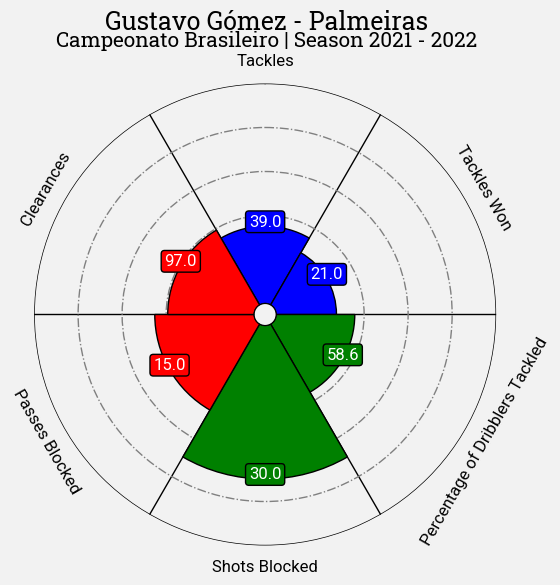

In [46]:
values: np.array = gustavo_gomez_series[names].to_numpy()[0]
values_normalized: np.array = np.round(((values - min_values) / max_values) * 100, 2)
slice_colors = ["blue"] * 2 + ["green"] * 2 + ["red"] * 2
text_colors = ["white"]*6
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    params=descriptive_names,
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    values_normalized,              # list of values
    figsize=(6, 6),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Gustavo Gómez - Palmeiras", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Campeonato Brasileiro | Season 2021 - 2022",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)
plt.show()

O *Radar Plot* do jogador Gustavo Gómez mostrou que se trata de um zagueiro de altíssimo nível. Seus números são muito altos e muito balanceados, demonstrando que se trata de um atleta completo e com muitos atributos defensivos.

Mais especificamente, possui valores consideráveis de *Tackles* e um bom aproveitamente nelas, além de ter um grande número de *Clearances* e *Shots/Passes Blocked*. Os valores analisados permite enxgergar que Gustavo Gómez também é um jogador difícil de ser driblado, mostrando ainda mais sua eficiẽncia na aprte defensiva.

Ao comparar os três *Radar Plots*, podemos enxegrar uma grande diferença entre os atletas. Júnior Alonso, numericamente, não parece estar no mesmo nível que os outros jogadores analisados, embora se trate de um grande jogador. Ayrton Lucas mostrou ter muita qualidade em *Tackles* e nem tanta em *Clearances*. Gustavo Gómez se mostrou um jogador ainda mais completo que os outros dois, tendo bons números para cada um dos atributos analisados.

## Questão 6
- Discuta as diferenças entre os radares das questões 3, 4 e 5. Quais são as principais diferenças entre os atributos relevantes para cada posição? Quais são as principais semelhanças? A impressão subjetiva que você tinha dos jogadores se comprovou pelos radares? Se não, por quê? Quais posições são mais difíceis de serem avaliadas por estatísticas?